In [1]:
import copy
import sys
import os

from isca_tools.utils.numerical import polyfit_phase

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import pandas as pd
from scipy import optimize, ndimage
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [23]:
exp_dir = 'aquaplanet/latent_heat_temp_only/'
exp_name = ['evap=0_1', 'depth=20/base']

var_keep = ['temp', 'sphum', 'height', 't_surf', 'swdn_sfc', 'lwup_sfc', 'lwdn_sfc',
            'flux_lhe', 'flux_t']
# get_heat_capacity(c_p_water)

# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

n_exp = len(exp_name)
lat_range = slice(30, 60)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
use_time_start = 2          # all after 2 years
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i], decode_times=True)
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=ds_use.time.dt.year>use_time_start, lat=lat_range)
    ds_use = ds_use.sel(pfull=np.inf, method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['net_fluxup_sfc'] = ds_use.lwup_sfc - ds_use.lwdn_sfc + ds_use.flux_lhe + ds_use.flux_t
    ds_base += [ds_use.load()]      # only keep after spin up
mixed_layer_depth = [isca_tools.load_namelist(exp_dir+exp_name[i])['mixed_layer_nml']['depth'] for i in range(n_exp)]
heat_capacity = [get_heat_capacity(c_p_water, mixed_layer_depth[i], rho_water) for i in range(n_exp)]

  0%|          | 0/2 [00:00<?, ?it/s]

Removing height from var_keep


/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [73]:
def get_annual_zonal_mean(ds):
    ds = ds.groupby("time.dayofyear").mean(dim="time").mean(dim='lon')
    ds['dayofyear'] = ds['dayofyear'] - 1           # for fourier stuff, expect first time index to be 0
    return ds

smooth_sz = 20   # smooth over 20 days
def get_smooth(ds, window=smooth_sz, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_anom(var, dim='dayofyear'):
    return var - var.mean(dim=dim)

In [72]:
ds = [get_annual_zonal_mean(ds_base[i]) for i in range(n_exp)]
n_lat = ds[0].lat.size
n_time = ds[0].dayofyear.size

In [60]:
sw_amp_coefs = {key: np.zeros((n_exp, n_lat, 1+int(key.replace('_harmonic', '')))) for key in ['1_harmonic', '2_harmonic']}
sw_fourier_fit = {key: np.zeros((n_exp, n_lat, n_time)) for key in ['1_harmonic', '2_harmonic']}
# temp_anom_fourier_fit = {key: np.zeros((n_lat, n_time)) for key in ['1_harmonic', '2_harmonic']}
for key in sw_amp_coefs:
    for j in range(n_exp):
        for i in range(n_lat):
            sw_amp_coefs[key][j, i] = fourier.get_fourier_fit(ds[j].dayofyear, ds[j].swdn_sfc[:, i], int(key.replace('_harmonic', '')))[1]
            # Fit SW fourier with no phase
            sw_fourier_fit[key][j, i] = fourier.fourier_series(ds[j].dayofyear, sw_amp_coefs[key][j, i], np.zeros(int(key.replace('_harmonic', ''))))
# Record phase of maxima / minima relative to extrema times of 1st harmonic of SW radiation
time_extrema_sw = {'min': int(ds[0].dayofyear[0]), 'max': int(ds[0].dayofyear[int(n_time/2)])}
time_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}
amp_extrema_temp = {key: {'simulated': np.zeros((n_exp, n_lat))} for key in ['min', 'max']}

smooth_ndays_temp_extrema = 20            # smoothing to temp annual mean to find date of hottest day
for j in range(n_exp):
    for i in range(n_lat):
        # No smoothing for '1_harmonic' as already fit smooth fourier solution
        time_extrema_temp['min']['simulated'][j, i], time_extrema_temp['max']['simulated'][j, i], \
            amp_extrema_temp['min']['simulated'][j, i], amp_extrema_temp['max']['simulated'][j, i] = \
            get_temp_extrema_numerical(ds[j].dayofyear, get_anom(ds[j].t_surf.isel(lat=i)), smooth_ndays_temp_extrema)

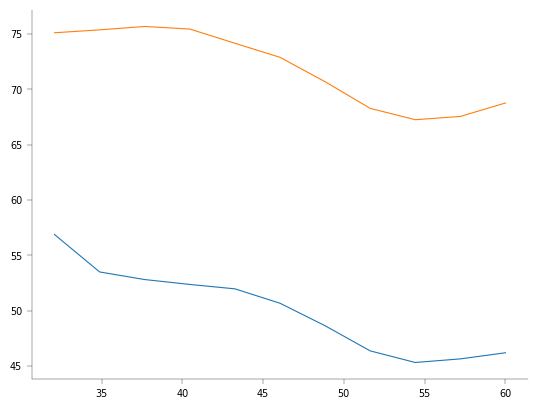

In [71]:
for i in range(n_exp):
    plt.plot(ds[i].lat, time_extrema_temp['max']['simulated'][i]-time_extrema_sw['max'])

In [133]:
gamma_params = np.zeros((n_exp, n_lat, 2))
for i in range(n_exp):
    for j in range(n_lat):
        # Compute gamma from the smoothed arrays
        gamma_params[i, j] = np.polyfit(get_smooth(get_anom(ds[i].t_surf.isel(lat=j))),
                                        get_smooth(ds[i].net_fluxup_sfc.isel(lat=j)), 1)

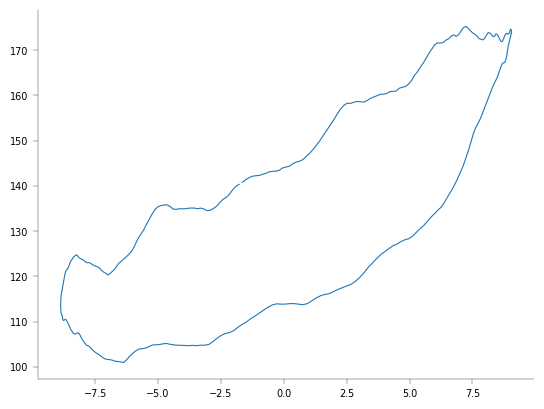

In [127]:
i = 1
j = -1
plt.plot(get_smooth(get_anom(ds[i].t_surf.isel(lat=j))), get_smooth(ds[i].net_fluxup_sfc.isel(lat=j)))


In [157]:
temp_anom_approx = {key: np.zeros((n_exp, n_lat, n_time)) for key in sw_amp_coefs}
for key in temp_anom_approx:
    for i in range(n_exp):
        for j in range(n_lat):
            ds_use = ds[i].isel(lat=j)
            gamma_resid = get_smooth(ds_use.net_fluxup_sfc) - np.polyval(gamma_params[i, j], get_anom(ds_use.t_surf))
            # Effective shortwave radiation is shortwave minus all of gamma that cannot be explained through a linear fit
            sw_eff = ds_use.swdn_sfc - gamma_resid
            temp_anom_approx[key][i, j] = get_temp_fourier_analytic(ds_use.dayofyear, sw_eff, heat_capacity[i],
                                                                    gamma_params[i, j, 0], n_harmonics_sw=int(key[0]))[0]

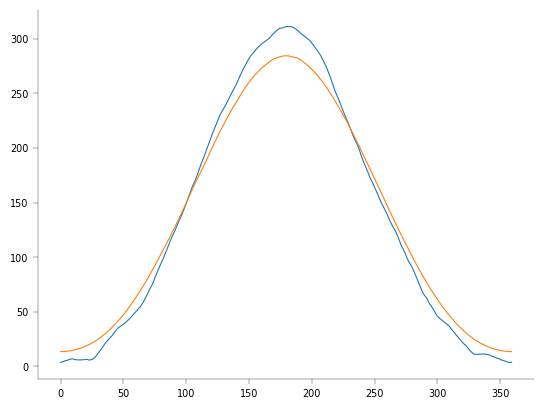

In [158]:
plt.plot(sw_eff)
plt.plot(ds_use.swdn_sfc)

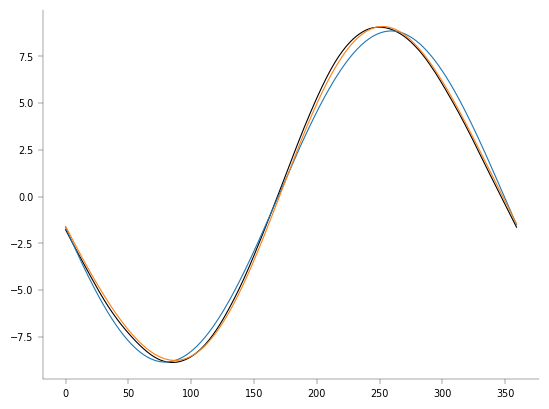

In [174]:
i = -1
j = -1
plt.plot(get_smooth(get_anom(ds[i].t_surf.isel(lat=j))), color='k')
for key in ['1_harmonic', '2_harmonic']:
    plt.plot(temp_anom_approx[key][i,j]-0*get_smooth(get_anom(ds[i].t_surf.isel(lat=j))))

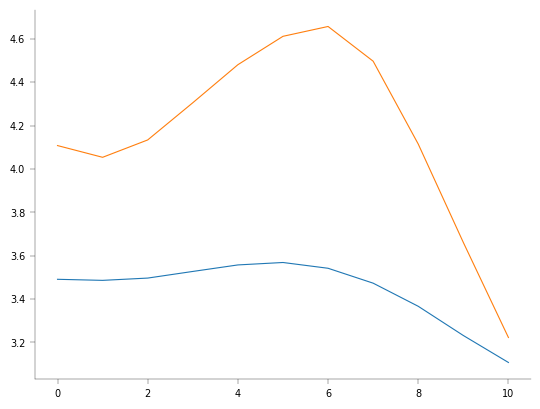

In [90]:
plt.plot(gamma_params[0][:,0])
plt.plot(gamma_params[1][:,0])